# Créer un chatbot sécurisé sur vos données d'entreprise

Les objectifs de cette démo sont de démontrer comment créer un Chatbot basé sur un LLM et des données d'entreprises sans risquer de compromettre l'image de l'entreprise 

Crédit : certains éléments de la présentation sont issus d'articles de James Briggs : 

- https://www.pinecone.io/learn/nemo-guardrails-intro/
- https://www.pinecone.io/learn/fast-retrieval-augmented-generation/



# Mitiger le risque

La première réaction d'un chef d'entreprise par rapport à l'idée de mettre en oeuvre un chatbot pour son entreprise devrait être de réfléchir aux risques. Par exemples : 

- les LLMs à la base des chatbots sont connus pour leurs haluciantions;
- des utilisateurs malveillants pourraient poser des questions inappropriées ou sans rapport avec l'entreprise
- le LLM pourrait, même sur des questions qui semblent correctes, répondre de manière inappropriée
- dans certains cas, on veut plus de contrôle sur la conversation afin d'être certain qu'elle se déroule dans les standards de communication d'entreprise

==> Nous avons besoin de pouvoir canaliser le LLM et de lui imposer de rester entre les rails de sécurités imposés par l'entreprise

# NVIDIA NeMo Guardrails

Maintenir le LLM dans les rails, c'est la première fonction de cet outil proposé par NVIDIA dans sa suite IA "NeMo"

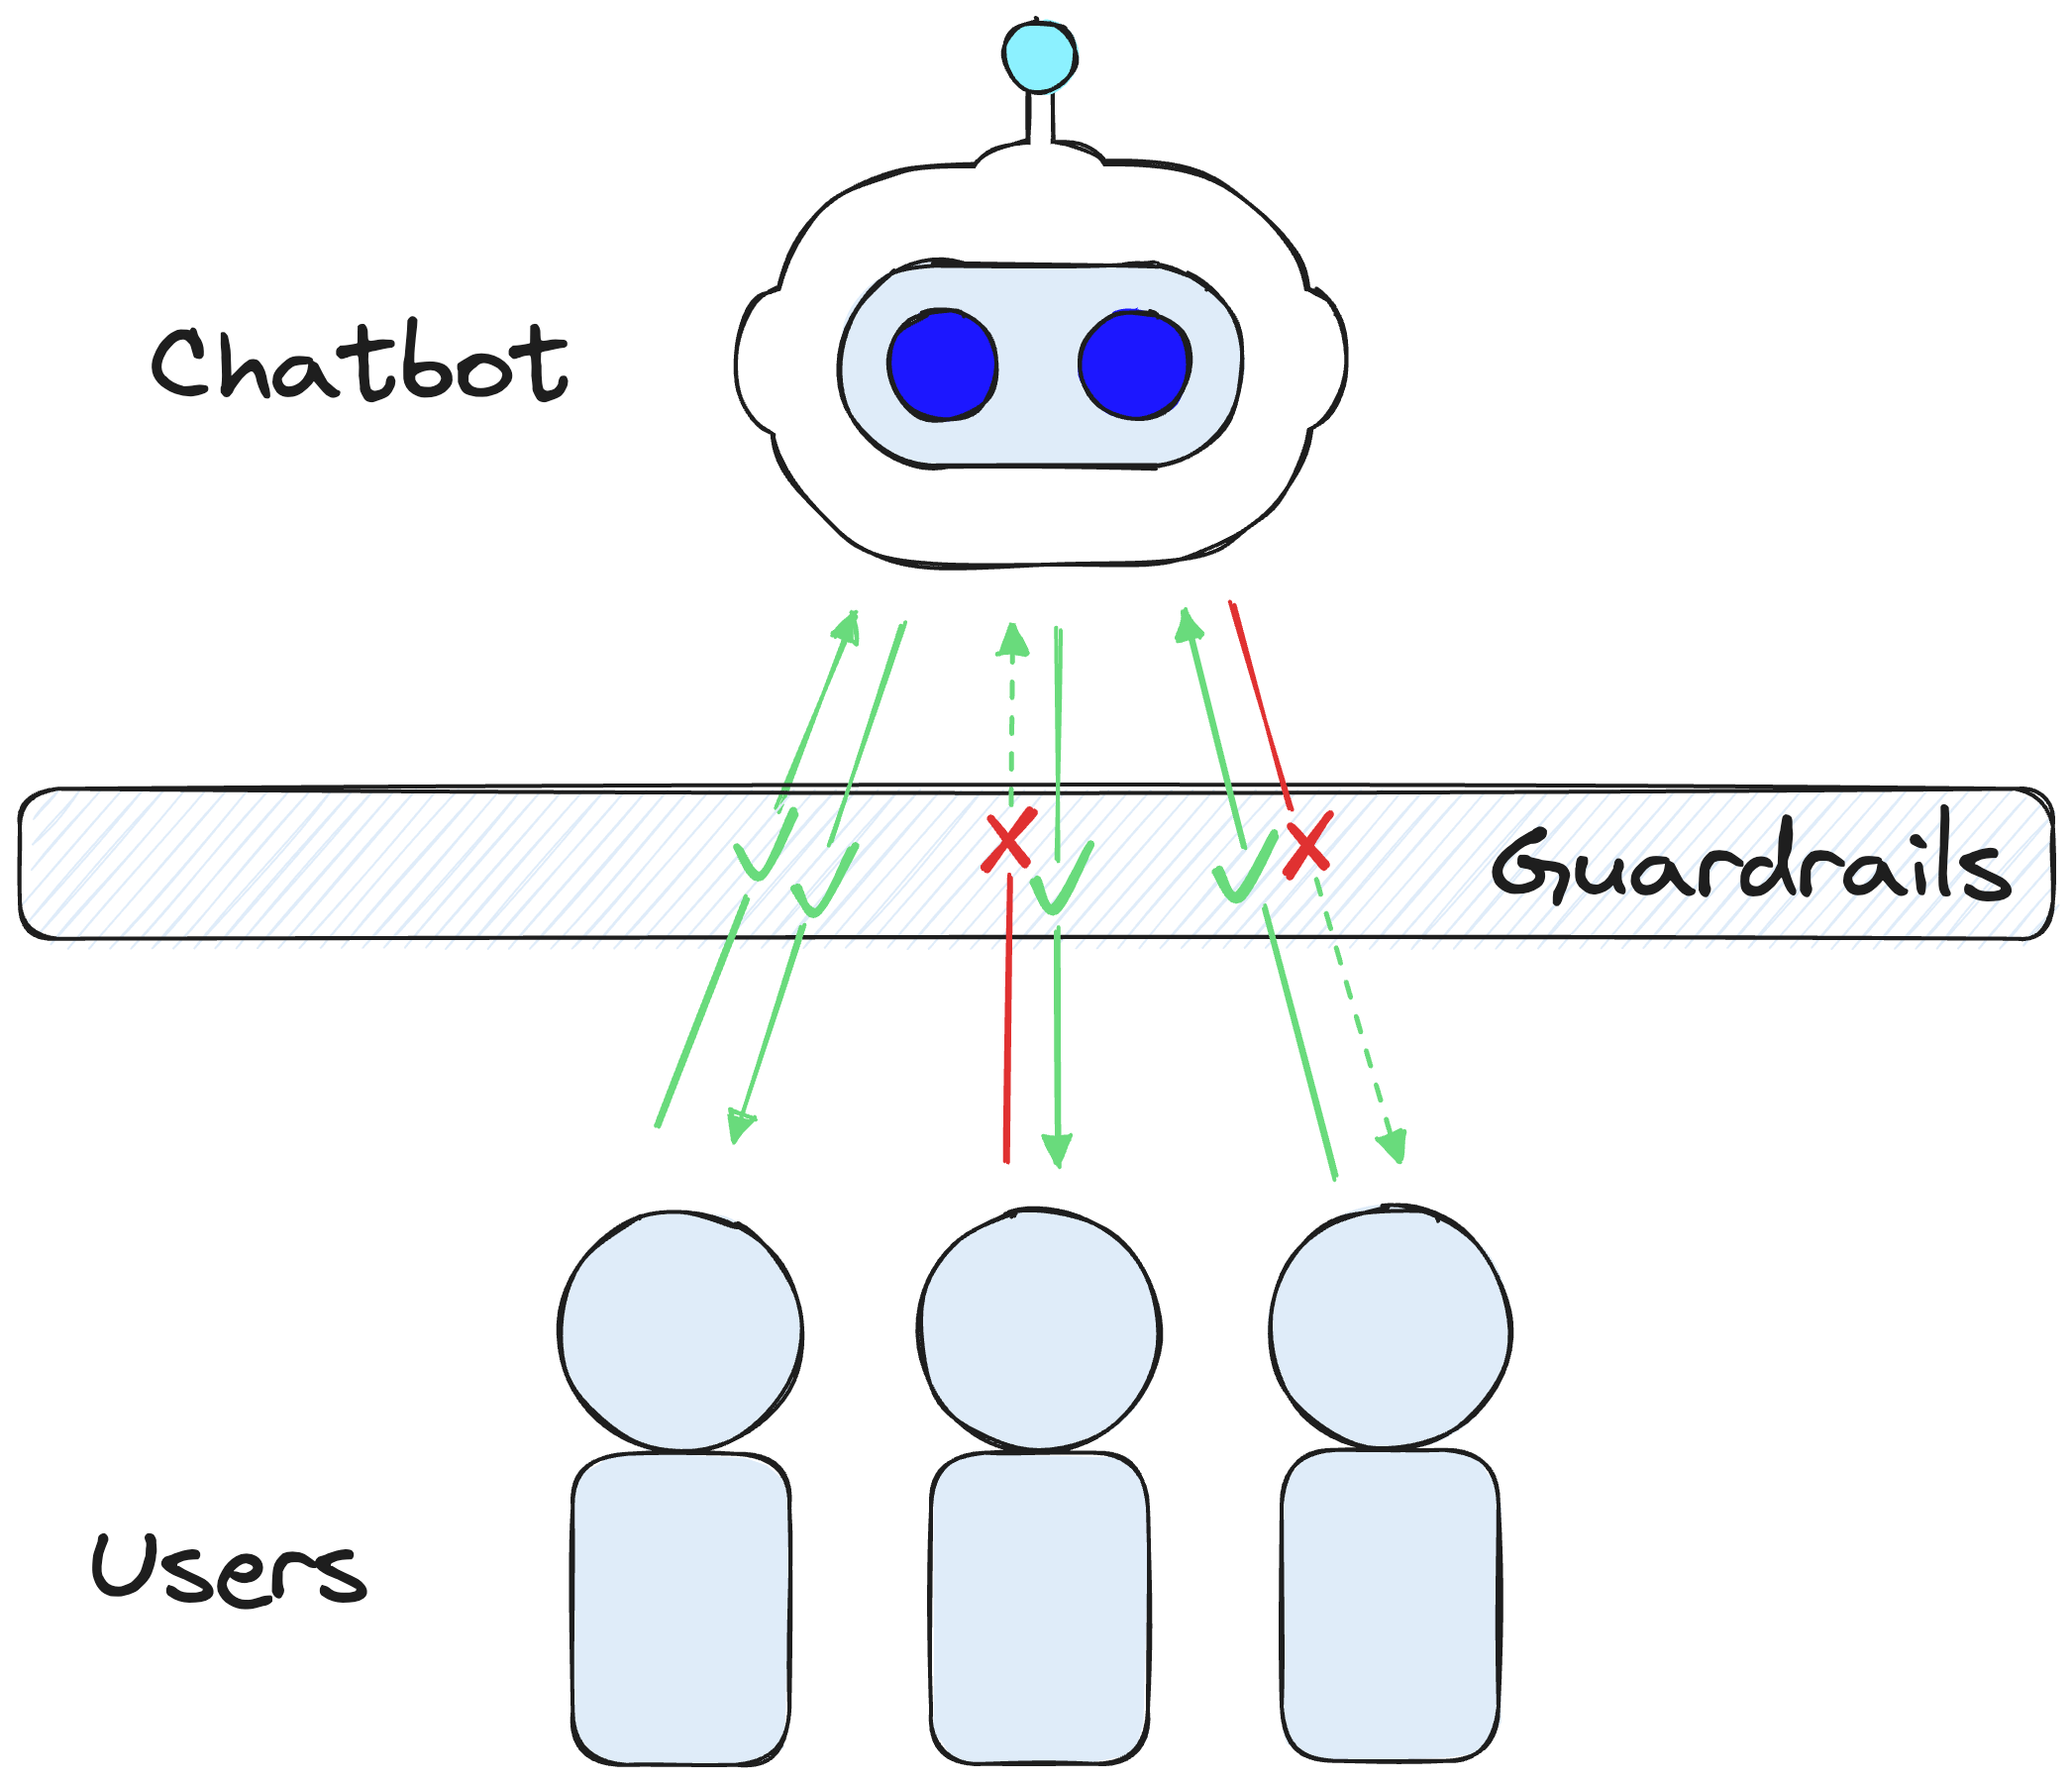

Guardrails fait appel à un moteur de règle pour canaliser le LLM.

Assez parlé pour l'instant : hands on !

# installer les composants requis

```pip install nemoguardrails openai```

Voir fichier install.sh

# Obtenir une clé OpenAI et la placer dans une variable d'environnement

La clé peut être obtenue du site suivant : https://platform.openai.com/account/api-keys

Il faut la placer dans la variable d'environnement ```OPENAI_API_KEY```

# Configurer le LLM utilisé par Guardrails

Nous avons besoin d'un ficher config.yaml qui doit comprendre au minimum les informations suivantes : 

```
models:
- type: main
  engine: openai
  model: text-davinci-003
```

  Voir fichier config.yaml

# Configurer les rails

Guardrails utilise le langage de description de règles Colang pour décrire les règles également appelées rails.

Voir la documentation de Colang ici : https://github.com/NVIDIA/NeMo-Guardrails/blob/main/docs/user_guide/colang-language-syntax-guide.md

Voici notre exemple de règles : 

```
# define niceties
define user express greeting
    "Bonjour"
    "Salut"
    "Comment vas-tu ?"

define flow greeting
    user express greeting
    bot express greeting
    bot ask how are you

# define limits
define user ask politics
    "Quel est ton avis sur la politique ?"
    "Que penses-tu du premier ministre?"
    "socialiste"
    "libéral"

define bot answer politics
    "Désolé, je suis un assistant d'entreprise. Je ne parle pas de politique."

define flow politics
    user ask politics
    bot answer politics
    bot offer help

define user speaks about holiday
    "J'ai besoin de vacances"
    "C'est bientôt le weekend"
    "Je suis plein d'énergie"

define bot answer holiday
    "Préférez-vous la plage ou la montagne ?"
    "J'irai bien skier avec vous !"
    "J'adorerais me détendre mais je suis un bot"

define flow holiday
    user speaks about holiday
    bot answer holiday
    bot offer help
```

voir fichier rails.co. 

In [1]:
from nemoguardrails import LLMRails, RailsConfig

# Lisons les fichiers de configuration
with open("rails.co", encoding="utf-8") as f:
    colang = f.read()
with open("config.yml") as f:
    yaml = f.read()

config = RailsConfig.from_content(yaml_content=yaml, colang_content=colang)


# Initialisons les rails
rails = LLMRails(config)


In [2]:
print(await rails.generate_async(prompt="Coucou !"))

Bonjour! Comment puis-je vous aider aujourd'hui?
How are you doing today?


In [3]:
print(await rails.generate_async(prompt="Je n'aime pas les socialistes"))

Désolé, je suis un assistant d'entreprise. Je ne parle pas de politique.
Is there anything else I can help you with?


In [4]:
print(await rails.generate_async(prompt="Je suis partant pour faire la fête"))

J'adorerais me détendre mais je suis un bot
Is there anything else I can help you with?


In [5]:
print(await rails.generate_async(prompt="Qui a inventé l'automobile ?"))

Désolé, je ne sais pas.


# Comment ça marche ?

La question posée par l'utilisateur est transformée en un vecteur normé représentant sa signification. Guardrails utilise un produi scalaire pour calculer la distance entre cette question et les prédicats présents dans ses rails

![Alt text](image.png)

# Chatbot sur vos données

les LLM comme ChatGPT ne connaissent pas nos données d'entreprise. Il y a deux méthodes pour adresser ce problème : 

- fine tuning : cette méthode consiste à poursuivre l'entrainement du LLM en lui faisant assimiler nos données d'entreprise pour créer un LLM propre à nos données
- RAG (Retrieval Augmented Generation) : cette méthode consiste à alimenter la conversation avec un extrait ciblé de données d'entreprises en fonction de la question posée. Dans ce cas c'est le LLM standard qui répond mais il se limite au contexte qui lui est imposé


# fine tuning : avantages et inconvénients

- +++ le fine tuning permet de créer un LLM qui connait nos données et est capable de répondre à une question sur la base de l'ensemble de sa connaissance composée des données sur lesquelles il a été entrainé additionnée à nos données d'entreprise
- --- Il n'est pas possible de retirer des données d'entraînement. Il est donc très compliqué de gérer des cas où certaines données expirent
- --- Le LLM répond sur l'ensemble de ses connaissances, mais il es difficile de lui imposer de donner plus de poids aux données d'entreprise et donc il est fort susceptible de mélanger dans ses réponses des éléments ciblés avec des éléments plus généraux et pas obligatoirement intéressants
- --- le fine tuning impose de créer un déploiement du modèle de langage entraîné ce qui peut être très coûteux et n'est pas toujours permis par les fonrnisseurs de LLM

==> bref, si le fine tuning est techniquement possible, il comporte beaucoup d'inconvénients qui ont amenés à réfléchir à une autre solution



# RAG - avantages et inconvénients

- --- RAG implique différents composants complémentaires dans l'infrastructure de la silution et est donc un concept plus complexe
- +++ RAG permet un peu mieux de canaliser le fonctionnement du LLM qui n'est utilisé que pour ses capacités à générer du contenu en non pour la connaissance issue de son entraînement
- +++ RAG ne nécessite pas de modifier l'entraînement du LLM et peut donc être utilisé sur base du LLM standard
- --- RAG est un peu meilleur que le fine tuning pour prévenir les hallucinations et les biais mais il reste des risques à gérer

RAG nécessite en plus du LLM de : 

- de découper les contenus un portions de taille raisonnable
- de pouvoir caractériser les contenus de manière sématitique sous forme d'un vecteur
- disposer d'une base de données avec une indexation vectorielle sématique des contenus

# Concentrons nous sur RAG

Voici un dessin qui en démontre bien le fonctionnement de RAG en mode naïf, simple, efficace.

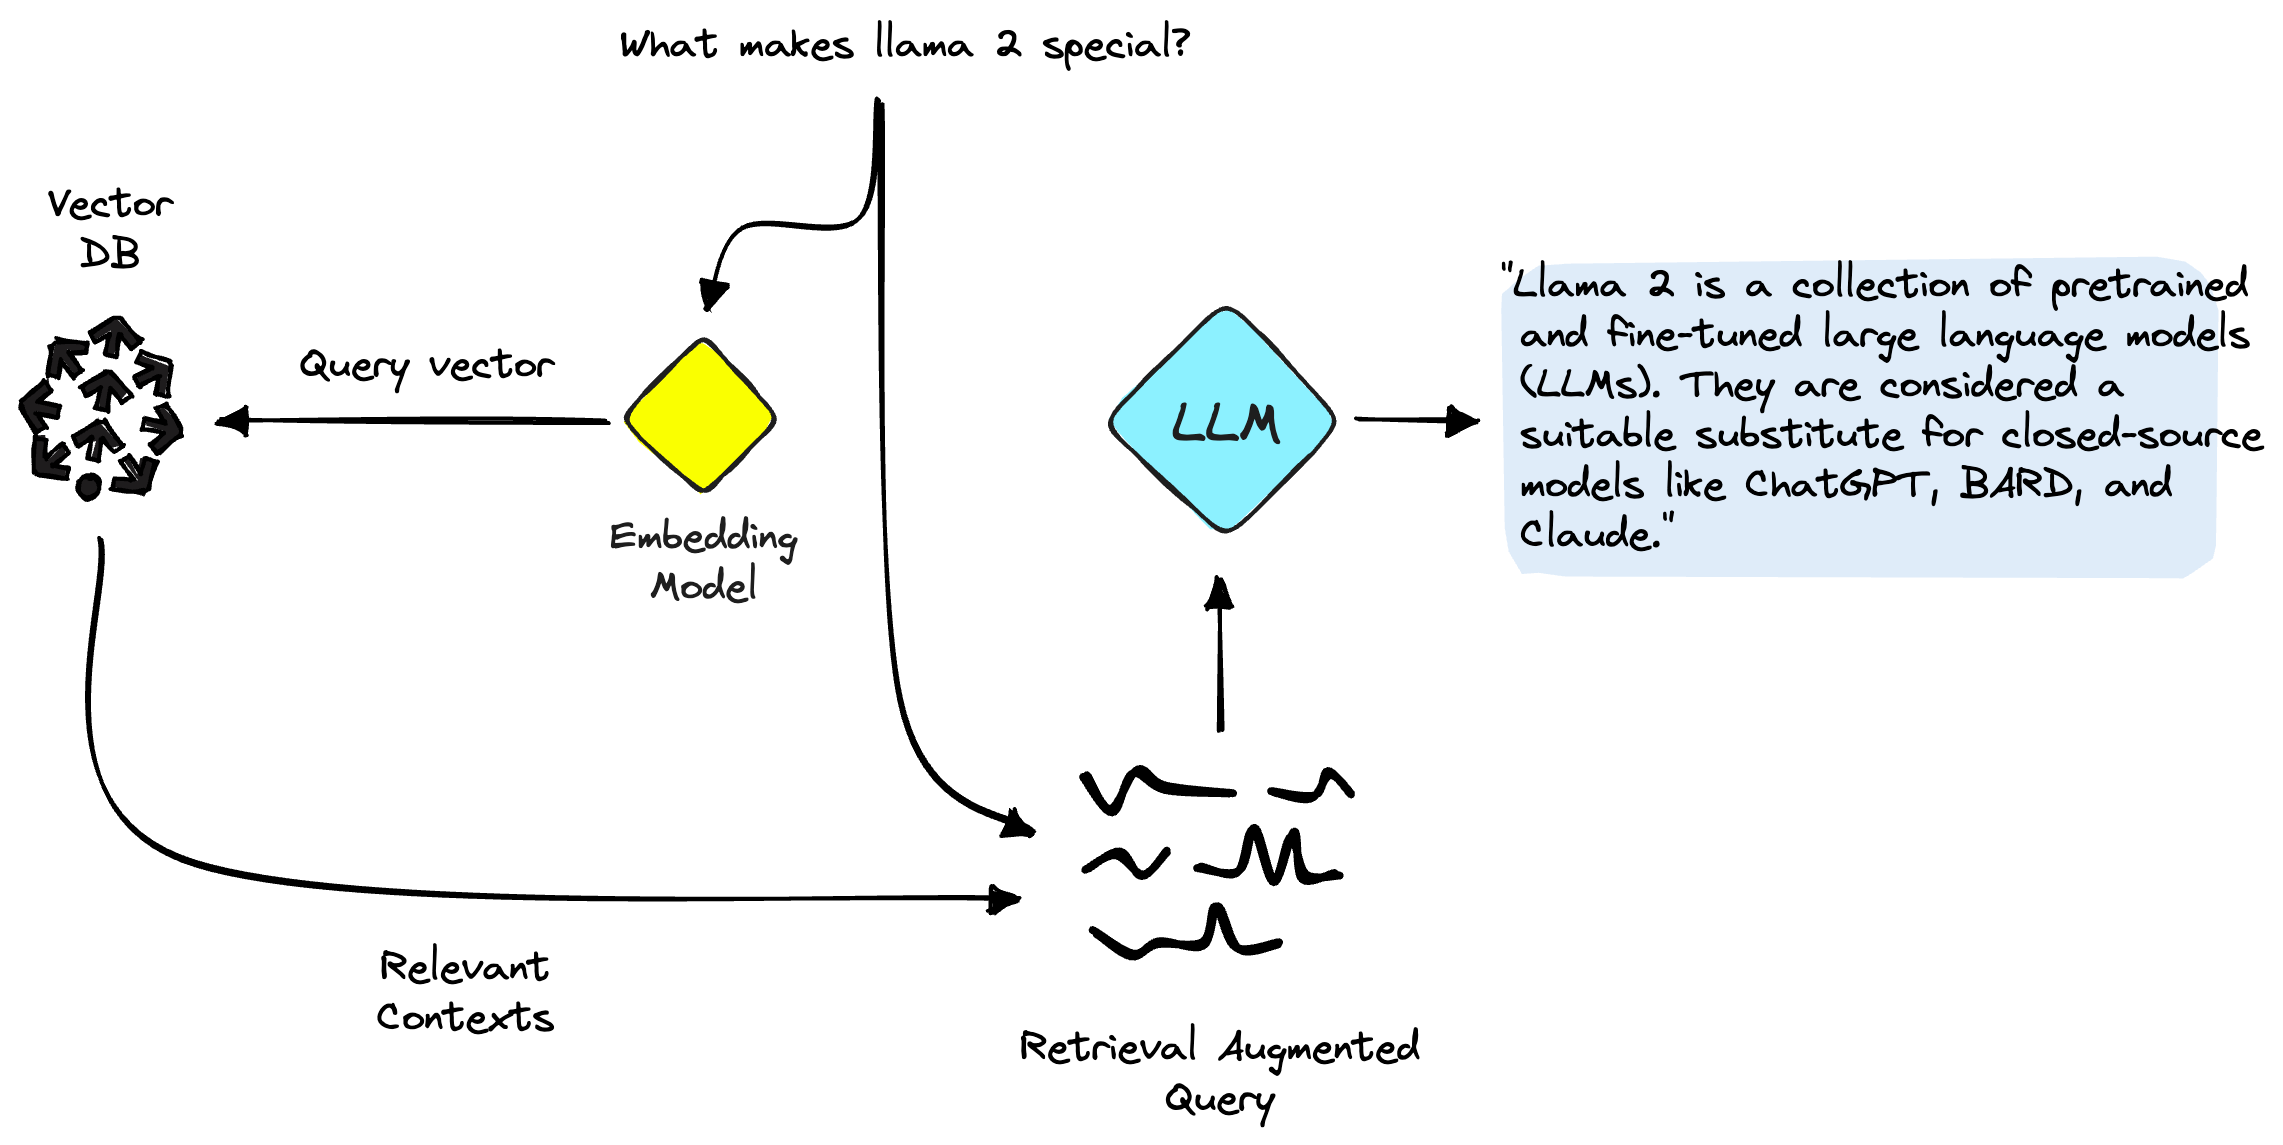

# Préparer et indexer les données

Pour mettre en oeuvre le RAG, nous devons commencer par préparer et indexer les données. Ceci comporte les étapes suivantes : 

- extraire : les documents à indexer : ils peuvent par exemples provenir d'une GED, d'une boite mail, d'un compte twitter, d'un site web ou d'une base de données
- convertir : le format d'origine des données est peut-être PDF, DOCX, PPTX, HTML, etc. L'objectif de cette étape est de tout ramener à un simple texte sans formattage
- découper : pour les besoins du RAG, nous avons besoin de découper ce texte en petit morceaux (chunks) de par exemples 400 caractères. On voudra sans doute un peu de recourvrement entre ces morceaux
- embedder : cette étape consiste à déterminer pour chaque chunk un vecteur qui en représente le sens. Il s'agit dans notre exemple d'un vecteur normé à 1536 composantes
- indexer : l'indexation sématique s'appuie sur les vecteurs élaborés à l'étape précédente.

À l'issue de ces opérations, nous disposerons d'un index capable de chercher des chunks sémantiquement proches d'une question posée. Schématiquement, une telle recherche passe par les étapes suivantes :

- embedding de la requête
- recherche des contenus dans l'index pour minimiser la distance entre le vecteur de la requête et le vecteur du chunk.

Note : il y a différentes méthodes pour déterminer cette distance. Nous allons utiliser la méthode des cosinus qui consiste en un produit scalaire des deux vecteurs normés. Le résultat est le cosinus de l'angle entre les deux vecteurs qui va de -1 (totalement différent) à +1 (totalement similaire)

# Découper
Nous allons ici partir du principe que l'extraction et la conversion sont déjà réalisés. Langchain propose un outil à cet effet

In [6]:
import os
def readFile(fn):
    with open(fn, "r", encoding="utf-8") as f:
        return f.read()

from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=50)
folder="./samples/"
texts=[readFile(folder+fn) for fn in os.listdir(folder)]

chunks = text_splitter.create_documents(texts=texts)

print(chunks)

[Document(page_content='Astrophysique\n\nArticle\nDiscussion\nLire\nModifier\nModifier le code\nVoir l’historique\n\nOutils\nAstrophysique', metadata={}), Document(page_content="Nébuleuse de la Lyre ou de l'Anneau (M57, NGC 6720, GC 4447), située dans la constellation de la Lyre.\nPartie de\t\nAstronomie, physique\nPratiqué par\t\nAstrophysicien ou astrophysicienne (d)\nChamps\t\nPlanétologie\nObjets\t\nTrou noir\névolution stellaire\nétoile à neutrons\nmatière noire\nénergie noire\nchamp magnétique stellaire\nchamp magnétique planétaire", metadata={}), Document(page_content='champ magnétique planétaire\nmodifier - modifier le code - modifier WikidataDocumentation du modèle', metadata={}), Document(page_content='Les Pléiades sont un amas ouvert, situé dans la constellation du Taureau.', metadata={}), Document(page_content="L’astrophysique (du grec astêr : étoile, astre et physis : science de la nature, physique) est une branche interdisciplinaire de l'astronomie qui concerne principale

# Embedding

Langchain comprend une classe très performante pour cette opération. Notons que l'embedding est en fait réalisé par le LLM OpenAI `text-embedding-ada-002` qui est très performant à cet effet. Il est possible d'utiliser d'autres modèles.

In [7]:
from langchain.embeddings import OpenAIEmbeddings

embedding = OpenAIEmbeddings()


In [8]:
# Calculons par exemples l'embedding du premier chunk
embedding.embed_query(chunks[0].page_content)

[0.00012018939115323598,
 0.021405317068806263,
 0.008215981604518606,
 -0.03129897665404937,
 -0.022850904805377242,
 0.011604493581224565,
 -0.022240840085113785,
 3.450264586550365e-05,
 -0.0006428060641405856,
 -0.025211589622343402,
 0.025211589622343402,
 -0.0006220837292279727,
 0.007101949829565563,
 -0.002112017729337387,
 -0.009237176816148947,
 0.006060861101913306,
 0.03432277618821915,
 -0.007413613206484165,
 -0.004804260137736002,
 -0.0035343971399849493,
 0.01769187875028537,
 0.014615030150498013,
 0.026246048730192657,
 0.019734269173546055,
 -0.004336765072358099,
 0.01652479930669862,
 0.008063465424452741,
 -0.036869131337862966,
 0.013050081317795543,
 -0.015755586458259845,
 0.039097193956446466,
 -0.010371101175801324,
 -0.008302185754070558,
 -0.022426512280436607,
 -0.037930116375504884,
 -0.001579868853303582,
 0.0087464722606944,
 0.0029873280105193853,
 0.007393720156123541,
 -0.0149996365747174,
 0.006770392936625045,
 0.03121940258996171,
 -0.017307272326

# Créer un index sur Pinecone

On pourrait le faire simplement dans l'interface web, mais c'est tellement plus fun de le coder ...



In [9]:
import os
import pinecone
from langchain.vectorstores import Pinecone

#print(os.getenv("PINECONE_API_KEY"))
#print(os.getenv("PINECONE_ENV"))

# Initialisons Pinecone
pinecone.init(
    api_key=os.getenv("PINECONE_API_KEY"),
    environment = os.getenv("PINECONE_ENV")
    )



In [10]:
import pinecone
import time
index_name = "astro"

# check if index already exists (it shouldn't if this is first time)
if index_name not in pinecone.list_indexes():
    # if does not exist, create index
    print("création de l'index ", index_name)
    pinecone.create_index(
        index_name,
        dimension=1536,
        metric='cosine'
    )
    # wait for index to be initialized
    while not pinecone.describe_index(index_name).status['ready']:
        time.sleep(1)
    
    # wait a bit more for index to be really initialized
    time.sleep(10)

    print("index ", index_name, "créé. Indexing...")
    search = Pinecone.from_documents(chunks, embedding, index_name=index_name)
    print("indexing done")
else:
    print("index ", index_name, "déjà existant")
    search = Pinecone.from_existing_index(index_name=index_name, embedding=embedding)

index  astro déjà existant


# Recherche dans l'index

Maintenant que nous disposons d'un index, nous pouvons chercher des extraits correspondant à une question

In [11]:
search.similarity_search("Quelle est la différence entre une étoile à neutrons et un magnétar ?")

[Document(page_content="Magnétar\n\nArticle\nDiscussion\nLire\nModifier\nModifier le code\nVoir l’historique\n\nOutils\n\nVue d'artiste d'un magnétar.\nUn magnétar ou une étoile magnétique, une magnétoile selon la dénomination officielle en France1, est une étoile à neutrons dont le champ magnétique est extrêmement intense et qui émet un rayonnement électromagnétique de haute énergie (rayons X et rayons gamma).", metadata={}),
 Document(page_content="À leur naissance, les étoiles à neutrons sont dotées d'une vitesse de rotation très élevée, de plusieurs dizaines de tours par seconde. Elles possèdent également un champ magnétique très intense, allant jusqu'à 1011 teslas. Leur intérieur est également très atypique, étant principalement composé de neutrons à l'état superfluide et en proportions plus modestes, de protons et d'électrons. Le milieu", metadata={}),
 Document(page_content="Une étoile à neutrons est un astre principalement composé de neutrons maintenus ensemble par les forces d

# Créer une fonction pour récupérer des contenus de cet index

Pour implémenter notre chatbot RAG avec Guardrails, il nous faut une fonction async qui prend une question en paramètre et rend une liste de textes utiles

In [12]:
import openai
import pinecone

async def retrieve(query: str) -> list:
    index = pinecone.Index("astro")
    # create query embedding
    res = openai.Embedding.create(input=[query], engine="text-embedding-ada-002")
    xq = res['data'][0]['embedding']
    # get relevant contexts from pinecone
    res = index.query(xq, top_k=5, include_metadata=True)
    # get list of retrieved texts
    #print(res)
    contexts = [x['metadata']['text'] for x in res['matches']]
    return contexts

# tester la méthode

In [13]:

# SUPPRIMER LE ASYNC POUR TESTER
retrieve("Quelle est la différence entre une étoile à neutrons et un magnétar ?")

<coroutine object retrieve at 0x000001F812A88A40>

# Méthode qui prend en charge le RAG pour Guardrails

In [14]:
async def rag(query: str, contexts: list) -> str:
    print("> RAG Called")  # we'll add this so we can see when this is being used
    context_str = "\n".join(contexts)
    # place query and contexts into RAG prompt
    prompt = f"""You are a helpful assistant, below is a query from a user and
    some relevant contexts. Answer the question given the information in those
    contexts. If you cannot find the answer to the question, say "I don't know".

    Contexts:
    {context_str}

    Query: {query}

    Answer: """
    # generate answer
    res = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        temperature=0.0,
        max_tokens=100
    )
    return res['choices'][0]['text']

# Nouveaux rails

On part de ceux quo ont déjà été montrés et on ajoute ceci : 

```
define user ask astro
    "Qu'est-ce qu'un trou noir ?"
    "Quelle est la différence entre une étoile et une planète ?"
    "Quelle belle supernova !"

define flow astro
    user ask astro
    $contexts = execute retrieve(query=$last_user_message)
    $answer = execute rag(query=$last_user_message, contexts=$contexts)
    bot $answer
```

In [23]:
from nemoguardrails import LLMRails, RailsConfig
from langchain.chat_models import ChatOpenAI

# Lisons les fichiers de configuration
with open("astro.co", encoding="utf-8") as f:
    colang = f.read()

with open("config.yml") as f:
    yaml = f.read()

config = RailsConfig.from_content(yaml_content=yaml, colang_content=colang)

In [24]:
rag_rails.register_action(action=retrieve, name="retrieve")
rag_rails.register_action(action=rag, name="rag")

In [27]:
print(await rag_rails.generate_async(prompt="Salutations"))

Bonjour! Comment puis-je vous aider aujourd'hui?
Bonjour! Comment puis-je vous aider aujourd'hui? Comment allez-vous?


In [26]:
resultat = await rag_rails.generate_async(prompt="Quelle est la différence entre une étoile à neutrons et un magnétar ?")

#affiche ce résultat en plusieurs lignes pour plus de lisibilité. Césure entre les mots evec des lignes de'environ 80 caractères
import textwrap
print("\n".join(textwrap.wrap(resultat, width=100)))




> RAG Called
 La principale différence entre une étoile à neutrons et un magnétar est que les magnétars possèdent
un champ magnétique extrêmement intense et émettent un rayonnement électromagnétique de haute
énergie (rayons X et rayons gamma). Les étoiles à neutrons possèdent également un champ magnétique,
mais il est moins intense et ell
